In [7]:
from keras import regularizers
import pandas as pd
import numpy as np
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.optimizers import Adam, RMSprop, Adamax
from keras.utils import to_categorical
from keras.utils import img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import math
import datetime
import time

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [8]:
# Default dimensions we found online
img_width, img_height = 224, 224

# Create a bottleneck file
top_model_weights_path = 'pytorch_bottleneck_fc_model_resnet50.h5'

# Loading up our datasets
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'

# Number of epochs to train top model
epochs = 100  # This has been changed after multiple model runs
# Batch size used by flow_from_directory and predict_generator
batch_size = 64

In [9]:
# Load pre-trained ResNet50 model in PyTorch
pytorch_model = models.resnet50(pretrained=True)

# Modify the last layer for feature extraction
num_ftrs = pytorch_model.fc.in_features
pytorch_model.fc = nn.Identity()

# Define transforms for images
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageFolder(train_data_dir, transform=transform)
validation_dataset = ImageFolder(validation_data_dir, transform=transform)
test_dataset = ImageFolder(test_data_dir, transform=transform)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Feature extraction for training data
train_features = []
train_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        features = pytorch_model(images)
        train_features.append(features)
        train_labels.append(labels)

train_features = torch.cat(train_features)
train_labels = torch.cat(train_labels)
np.save('train_features_resnet50.npy', train_features.numpy())
np.save('train_labels_resnet50.npy', train_labels.numpy())

# Feature extraction for validation data
validation_features = []
validation_labels = []

with torch.no_grad():
    for images, labels in validation_loader:
        features = pytorch_model(images)
        validation_features.append(features)
        validation_labels.append(labels)

validation_features = torch.cat(validation_features)
validation_labels = torch.cat(validation_labels)
np.save('validation_features_resnet50.npy', validation_features.numpy())
np.save('validation_labels_resnet50.npy', validation_labels.numpy())

# Feature extraction for test data
test_features = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        features = pytorch_model(images)
        test_features.append(features)
        test_labels.append(labels)

test_features = torch.cat(test_features)
test_labels = torch.cat(test_labels)
np.save('test_features_resnet50.npy', test_features.numpy())
np.save('test_labels_resnet50.npy', test_labels.numpy())

# Load features and labels
train_data = np.load('train_features_resnet50.npy')
train_labels = np.load('train_labels_resnet50.npy')
validation_data = np.load('validation_features_resnet50.npy')
validation_labels = np.load('validation_labels_resnet50.npy')
test_data = np.load('test_features_resnet50.npy')
test_labels = np.load('test_labels_resnet50.npy')

# Convert target labels to one-hot encoded format
train_labels = to_categorical(
    train_labels, num_classes=len(train_dataset.classes))
validation_labels = to_categorical(
    validation_labels, num_classes=len(validation_dataset.classes))
test_labels = to_categorical(
    test_labels, num_classes=len(test_dataset.classes))

In [10]:
# Define the model architecture using Keras
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=len(train_dataset.classes), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_accuracy', patience=15, verbose=1, mode='max')

# Train the model
history = model.fit(train_data, train_labels,
                    epochs=200,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    callbacks=[early_stopping])

# Save the trained model
model.save(top_model_weights_path)

# Evaluate the model on the test data
eval_loss, eval_accuracy = model.evaluate(
    test_data, test_labels, batch_size=batch_size, verbose=1)

# Print the evaluation results
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

c:\Users\Bhuvan.L.Poojari\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
24/24 [==============================] - 5s 39ms/step - loss: 3.1660 - accuracy: 0.0448 - val_loss: 2.9111 - val_accuracy: 0.1280
Epoch 2/200
24/24 [==============================] - 0s 15ms/step - loss: 3.0299 - accuracy: 0.0587 - val_loss: 2.8887 - val_accuracy: 0.1890
Epoch 3/200
24/24 [==============================] - 1s 21ms/step - loss: 2.9906 - accuracy: 0.0692 - val_loss: 2.8563 - val_accuracy: 0.2622
Epoch 4/200
24/24 [==============================] - 0s 14ms/step - loss: 2.9694 - accuracy: 0.0811 - val_loss: 2.7994 - val_accuracy: 0.2744
Epoch 5/200
24/24 [==============================] - 0s 13ms/step - loss: 2.9291 - accuracy: 0.1009 - val_loss: 2.7298 - val_accuracy: 0.3171
Epoch 6/200
24/24 [==============================] - 0s 18ms/step - loss: 2.9058 - accuracy: 0.1081 - val_loss: 2.6558 - val_accuracy: 0.3659
Epoch 7/200
24/24 [==============================] - 0s 15ms/step - loss: 2.8659 - accuracy: 0.1411 - val_loss: 2.6080 - val_accuracy: 0.4268
Epoch 

In [11]:
from keras.utils import img_to_array, load_img
from PIL import Image
import torchvision.transforms as transforms
import torch
import time
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd

In [12]:
filepath = 'model_save_resnet50.h5'
keras.models.save_model(model, filepath)

In [13]:
model.save('saveresnet50.h5')

In [14]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 20)                2580      
                                                                 
Total params: 1,117,332
Trainable params: 1,117,332
Non-

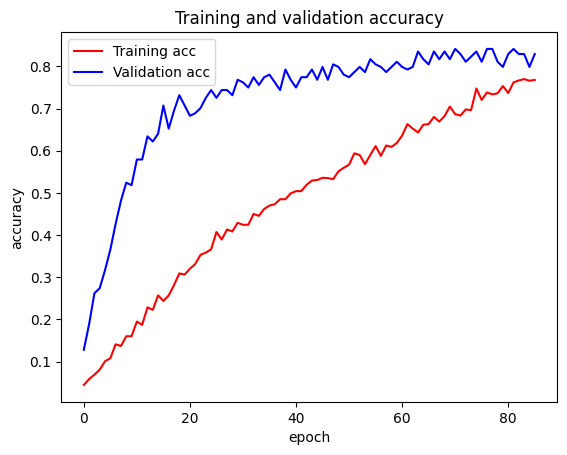

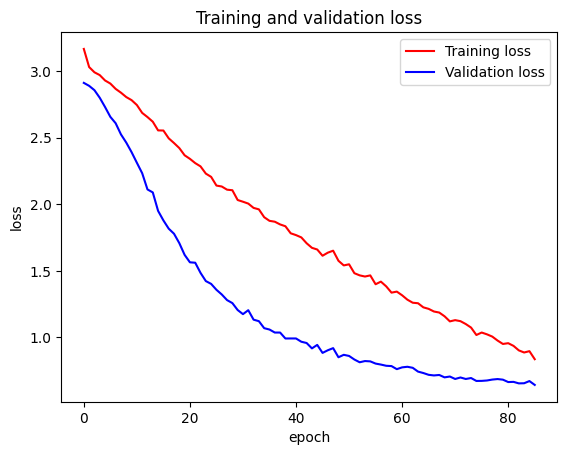

In [15]:
# Graphing our training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [16]:
model.evaluate(test_data, test_labels)

6/6 [==============================] - 0s 5ms/step - loss: 0.5790 - accuracy: 0.8415


[0.5790412425994873, 0.8414633870124817]

In [17]:
print('test data', test_data)
preds = np.round(model.predict(test_data), 0)
# to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[0.02755446 0.83683234 0.5196737  ... 0.32807747 0.8785982  0.2178119 ]
 [0.00183442 0.26469406 1.2279692  ... 0.10221719 0.14439233 0.16885908]
 [0.43356758 0.7116694  0.6441637  ... 0.6326402  0.04121311 0.24290466]
 ...
 [0.8153277  1.6558106  0.46559602 ... 0.4558041  0.5592092  0.36688653]
 [0.03631649 0.43192038 0.11520728 ... 0.06678393 0.23228016 0.06285529]
 [0.14182565 0.5403658  0.35332608 ... 0.37761444 0.15881051 0.13810802]]
6/6 [==============================] - 0s 3ms/step
rounded test_labels [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [18]:
animals = ['bear', 'cougar', 'coyote', 'cow', 'crocodiles', 'deer', 'elephant', 'giraffe', 'goat',
           'gorilla', 'horse', 'kangaroo', 'leopard', 'lion', 'panda', 'penguin', 'sheep', 'skunk', 'tiger', 'zebra']
classification_metrics = metrics.classification_report(
    test_labels, preds, target_names=animals)
print(classification_metrics)

              precision    recall  f1-score   support

        bear       1.00      0.50      0.67        10
      cougar       0.83      0.50      0.62        10
      coyote       1.00      0.90      0.95        10
         cow       1.00      0.40      0.57        10
  crocodiles       1.00      1.00      1.00        10
        deer       0.67      0.40      0.50        10
    elephant       1.00      0.80      0.89        10
     giraffe       1.00      0.50      0.67         6
        goat       1.00      0.44      0.62         9
     gorilla       0.86      1.00      0.92         6
       horse       1.00      1.00      1.00        10
    kangaroo       1.00      0.86      0.92         7
     leopard       1.00      0.70      0.82        10
        lion       1.00      0.78      0.88         9
       panda       1.00      1.00      1.00         8
     penguin       1.00      1.00      1.00         5
       sheep       1.00      0.80      0.89         5
       skunk       1.00    

c:\Users\Bhuvan.L.Poojari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [20]:
confusion_matrix = confusion_matrix(categorical_test_labels, categorical_preds)

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(10, 8)):  # Adjust the figsize as per your preference
    # Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Set figure size
    plt.figure(figsize=figsize)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    # Rotate x-labels by 90 degrees
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Increase x-coordinate for more horizontal space
        plt.text(j, i, format(cm[i, j], fmt), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


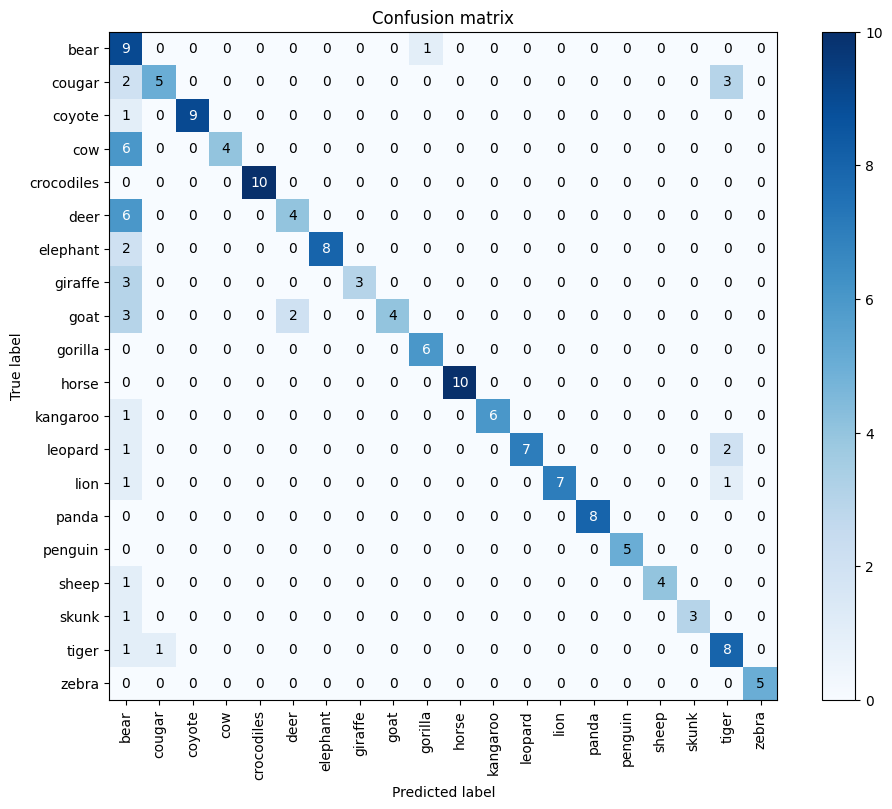

In [22]:
plot_confusion_matrix(confusion_matrix, ['bear', 'cougar', 'coyote', 'cow', 'crocodiles', 'deer', 'elephant', 'giraffe',
                      'goat', 'gorilla', 'horse', 'kangaroo', 'leopard', 'lion', 'panda', 'penguin', 'sheep', 'skunk', 'tiger', 'zebra'])

Normalized confusion matrix


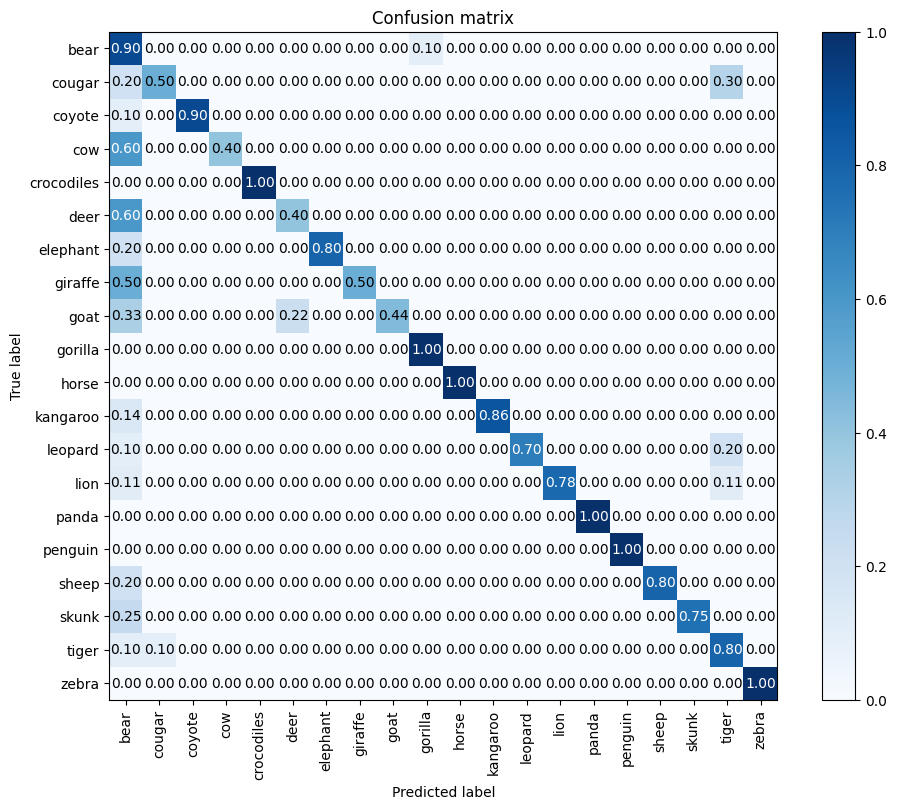

In [23]:
# Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix,
                      ['bear', 'cougar', 'coyote', 'cow', 'crocodiles', 'deer', 'elephant', 'giraffe', 'goat', 'gorilla',
                          'horse', 'kangaroo', 'leopard', 'lion', 'panda', 'penguin', 'sheep', 'skunk', 'tiger', 'zebra'],
                      normalize=True)

In [24]:
# Assuming `pytorch_model` is defined and loaded
def read_image(path):
    image = load_img(path, target_size=(224, 224))
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    image = image.reshape((1,) + image.shape)  # Add batch dimension
    return image


def test_single_image(path):
    animals = ['bear', 'cougar', 'coyote', 'cow', 'crocodiles', 'deer', 'elephant', 'giraffe', 'goat',
               'gorilla', 'horse', 'kangaroo', 'leopard', 'lion', 'panda', 'penguin', 'sheep', 'skunk', 'tiger', 'zebra']

    # Read and preprocess the image
    image = read_image(path)
    time.sleep(0.5)

    # Convert image to torch tensor
    image = torch.tensor(image, dtype=torch.float32)
    # Change dimension order to [batch_size, channels, height, width]
    image = image.permute(0, 3, 1, 2)
    image = image.to('cpu')  # Set to 'cuda' if you're using GPU

    # Extract features using the pretrained ResNet50 model
    with torch.no_grad():
        features = pytorch_model(image)

    # Convert features to numpy array
    features = features.detach().numpy()

    # Make predictions using the trained model
    preds = model.predict(features)

    # Print individual class probabilities
    for idx, animal, prob in zip(range(0, 20), animals, preds[0]):
        print("ID: {}, Label: {} {}%".format(
            idx, animal, round(prob * 100, 2)))

    print('Final Decision:')
    time.sleep(0.5)

    # Simulate decision-making process
    for x in range(3):
        print('.'*(x+1))
        time.sleep(0.2)

    # Determine the predicted class
    class_prob = list(preds[0])
    max_prob = max(class_prob)
    pred_class = class_prob.index(max_prob)
    print("ID: {}, Label: {}".format(pred_class, animals[pred_class]))

    return load_img(path)

In [25]:
path = 'data/test/crocodiles/images656.jpg'

1/1 [==============================] - 0s 16ms/step
ID: 0, Label: bear 5.17%
ID: 1, Label: cougar 4.31%
ID: 2, Label: coyote 3.89%
ID: 3, Label: cow 7.08%
ID: 4, Label: crocodiles 9.41%
ID: 5, Label: deer 2.34%
ID: 6, Label: elephant 6.34%
ID: 7, Label: giraffe 7.77%
ID: 8, Label: goat 6.76%
ID: 9, Label: gorilla 1.88%
ID: 10, Label: horse 6.84%
ID: 11, Label: kangaroo 3.05%
ID: 12, Label: leopard 6.92%
ID: 13, Label: lion 5.83%
ID: 14, Label: panda 3.7%
ID: 15, Label: penguin 3.47%
ID: 16, Label: sheep 2.3%
ID: 17, Label: skunk 2.01%
ID: 18, Label: tiger 3.52%
ID: 19, Label: zebra 7.41%
Final Decision:
.
..
...
ID: 4, Label: crocodiles


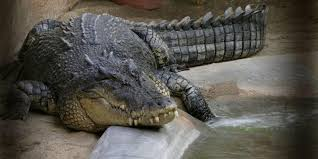

In [26]:
test_single_image(path)

In [27]:
# Compute precision, recall, F1 score
precision = metrics.precision_score(
    np.argmax(test_labels, axis=1), np.argmax(preds, axis=1), average='weighted')
recall = metrics.recall_score(
    np.argmax(test_labels, axis=1), np.argmax(preds, axis=1), average='weighted')
f1_score = metrics.f1_score(np.argmax(test_labels, axis=1), np.argmax(
    preds, axis=1), average='weighted')

# Compute confusion matrix
conf_matrix = metrics.confusion_matrix(
    np.argmax(test_labels, axis=1), np.argmax(preds, axis=1))

# Calculate FAR and FRR
far = np.sum(conf_matrix.sum(axis=0) - np.diag(conf_matrix)) / \
    np.sum(conf_matrix.sum(axis=1))
frr = np.sum(conf_matrix.sum(axis=1) - np.diag(conf_matrix)) / \
    np.sum(conf_matrix.sum(axis=1))

# Print out the results
print("Accuracy: {:.2f}%".format(eval_accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1_score))
print("False Acceptance Rate (FAR): {:.2f}".format(far))
print("False Rejection Rate (FRR): {:.2f}".format(frr))

# Calculate mAP
average_precision = metrics.average_precision_score(
    test_labels, preds, average=None)
mAP = np.mean(average_precision)
print("Mean Average Precision (mAP): {:.2f}".format(mAP))

Accuracy: 84.15%
Precision: 0.89
Recall: 0.76
F1 Score: 0.79
False Acceptance Rate (FAR): 0.24
False Rejection Rate (FRR): 0.24
Mean Average Precision (mAP): 0.73
